In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import f_classif
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
#tournament score from 1985 to 2021
scores = pd.read_csv('/Users/codygreene/Library/CloudStorage/OneDrive-USCMarshallSchoolofBusiness/0_DSO579 (Sports Analytics)/Final Project/Tournament_Scores_1981-2021.csv')
scores = scores[scores["ROUND"] != 0] #filter out first four (play in) games

scores["UPSET"] = scores.apply(lambda row: 1 if row["WSEED"] > row["LSEED"] else 0, axis=1)

scores['SEED COMBINATION'] = scores.apply(lambda row: f"{min(row['WSEED'], row['LSEED'])}&{max(row['WSEED'], row['LSEED'])}", axis=1)

# Calculate the count of each 'SEED COMBINATION' and assign it to each row
scores['COMBINATION COUNT'] = scores.groupby('SEED COMBINATION')['SEED COMBINATION'].transform('count')

scores.head()

,YEAR,ROUND,WSEED,WTEAM,WSCORE,LSEED,LTEAM,LSCORE,UPSET,SEED COMBINATION,COMBINATION COUNT
0,2021,6,1,Baylor,86,1,Gonzaga,70,0,1&1,21
1,2021,5,1,Gonzaga,93,11,UCLA,90,0,1&11,9
2,2021,5,1,Baylor,78,2,Houston,59,0,1&2,66
3,2021,4,2,Houston,67,12,Oregon State,61,0,2&12,2
4,2021,4,1,Baylor,81,3,Arkansas,72,0,1&3,36


In [3]:
#data of each tournament games from 2008 to 2022
gamedata = pd.read_csv('/Users/codygreene/Library/CloudStorage/OneDrive-USCMarshallSchoolofBusiness/0_DSO579 (Sports Analytics)/Final Project/Tournament_Game_Data_2008-2022.csv')
gamedata = gamedata[gamedata["YEAR"] != 2023] #filter out 2023 data because it's imcomplete

gamedata.rename(columns={"TEAM ROUND": "ROUND ADVANCED"}, inplace=True) #change column name
gamedata = gamedata.drop("TEAM.1", axis=1) #drop column

round_mapping = {64: 1, 32: 2, 16: 3, 8: 4, 4: 5, 2: 6, 1: 6}

#round of 64 = 1
#round of 32 = 2
#sweet 16 = 3
#elite 8 = 4
#final 4 = 5
#national championsip = 6

# Replace the values in "ROUND ADVANCED" and "CURRENT ROUND" column using the mapping
gamedata["ROUND ADVANCED"] = gamedata["ROUND ADVANCED"].replace(round_mapping)
gamedata["CURRENT ROUND"] = gamedata["CURRENT ROUND"].replace(round_mapping)

gamedata.head()

,YEAR,SEED,TEAM,ROUND ADVANCED,CURRENT ROUND,KENPOM ADJUSTED EFFICIENCY,KENPOM ADJUSTED OFFENSE,KENPOM ADJUSTED DEFENSE,KENPOM ADJUSTED TEMPO,BARTTORVIK ADJUSTED EFFICIENCY,...,OP O REB %,OP D REB %,BLOCKED %,TURNOVER % DEFENSE,WINS ABOVE BUBBLE,WIN %,POINTS PER POSSESSION OFFENSE,POINTS PER POSSESSION DEFENSE,SCORE,ID
0,2022,1,Gonzaga,3,1,33.0,121.8,88.8,72.5,31.8,...,23.0,71.0,6.6,17.0,6.7,89.66,1.190,0.885,93,1
1,2022,16,Georgia St.,1,1,1.8,101.5,99.7,67.1,1.4,...,30.7,67.2,8.9,22.7,-5.2,60.00,0.993,0.978,72,2
2,2022,8,Boise St.,1,1,16.4,108.4,92.0,64.6,15.2,...,21.9,69.4,8.9,20.1,3.5,78.79,1.038,0.928,53,3
3,2022,9,Memphis,2,1,16.2,110.4,94.1,70.3,17.5,...,31.0,62.5,9.1,20.9,1.4,67.74,1.056,0.957,64,4
4,2022,5,Connecticut,1,1,19.3,113.9,94.6,64.9,18.6,...,27.5,62.0,8.3,18.0,3.2,71.88,1.099,0.953,63,5


In [4]:
#data of each teams played in tournament from 2008 to 2022
teamdata = pd.read_csv('/Users/codygreene/Library/CloudStorage/OneDrive-USCMarshallSchoolofBusiness/0_DSO579 (Sports Analytics)/Final Project/Tournament_Team_Data_2008-2022.csv')
teamdata = teamdata.drop("TEAM.1", axis=1)
teamdata.rename(columns={"ROUND": "ROUND ADVANCED"}, inplace=True) #change column name

teamdata.head()

,YEAR,SEED,TEAM,ROUND ADVANCED,KENPOM ADJUSTED EFFICIENCY,KENPOM ADJUSTED OFFENSE,KENPOM ADJUSTED DEFENSE,KENPOM ADJUSTED TEMPO,BARTTORVIK ADJUSTED EFFICIENCY,BARTTORVIK ADJUSTED OFFENSE,...,3PT RATE DEFENSE,OP ASSIST %,OP O REB %,OP D REB %,BLOCKED %,TURNOVER % DEFENSE,WINS ABOVE BUBBLE,WIN %,POINTS PER POSSESSION OFFENSE,POINTS PER POSSESSION DEFENSE
0,2022,1,Kansas,1,25.5,119.4,93.9,69.1,27.2,120.1,...,34.2,47.5,28.9,66.6,7.8,18.4,10.4,82.35,1.119,0.970
1,2022,1,Arizona,16,27.2,119.6,92.4,72.2,25.6,117.4,...,34.5,46.8,28.3,65.5,7.0,17.7,8.8,91.18,1.155,0.922
2,2022,1,Gonzaga,16,33.0,121.8,88.8,72.5,31.8,120.2,...,33.9,40.6,23.0,71.0,6.6,17.0,6.7,89.66,1.190,0.885
3,2022,1,Baylor,32,26.3,117.9,91.6,67.2,26.3,116.6,...,35.9,55.5,28.4,63.7,7.3,22.9,8.9,81.25,1.112,0.925
4,2022,2,Duke,4,23.7,119.4,95.7,67.4,25.8,119.9,...,33.8,51.8,28.5,68.1,8.1,16.1,7.2,82.35,1.169,0.979


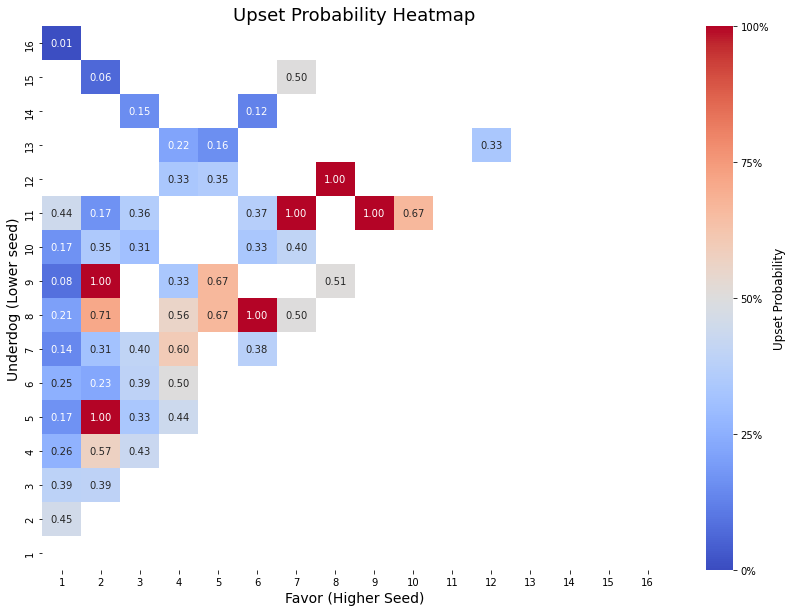

In [5]:
# Create a pivot table with the number of upsets (count of "Upset" occurrences) for each seed combination
pivot_upset = pd.pivot_table(scores, values='UPSET', index='LSEED', columns='WSEED', aggfunc='sum')

# Create a cross-tabulation to get the total number of occurrences (count of both "Upset" and "Favor" occurrences) for each seed combination
pivot_total = pd.pivot_table(scores, values='COMBINATION COUNT', index='LSEED', columns='WSEED', aggfunc='mean')

# Create a DataFrame to store the upset probabilities
upset_prob = pivot_upset / pivot_total

upset_prob = upset_prob.transpose()

# Define the custom order for the y-axis (from smallest to largest seed)
custom_order = sorted(scores['WSEED'].unique(), reverse=True)

# Reorder the y-axis index to start from smallest to largest seed
upset_prob = upset_prob.reindex(index=custom_order)

# Replace all 0 values with NaN
upset_prob.replace(0, np.nan, inplace=True)

# Create the heatmap using Matplotlib and Seaborn
fig, ax = plt.subplots(figsize=(14, 10))

# Set the color map to 'coolwarm' for the blue theme
cmap = 'coolwarm'

heatmap = sns.heatmap(upset_prob, annot=True, cmap=cmap, fmt=".2f", vmin=0, vmax=1, ax=ax)

# Customize the heatmap
heatmap.set_title('Upset Probability Heatmap', fontsize=18)
heatmap.set_xlabel('Favor (Higher Seed)', fontsize=14)
heatmap.set_ylabel('Underdog (Lower seed)', fontsize=14)

# Add a color bar
cbar = heatmap.collections[0].colorbar
cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
cbar.set_label('Upset Probability', fontsize=12)

# Show the heatmap
plt.show()


In [6]:
#my definition of upset
#seed difference in 5 seems to be a cutoff where the chances of the lower seed have a significantly lower chances of winning
#now I would like to look into the reason behind why upsets happen

In [7]:
#filter all data to 2008-2021
scores_filtered = scores[(scores["YEAR"] >= 2008) & (scores["YEAR"] <= 2021)]
gamedata_filtered = gamedata[(gamedata["YEAR"] >= 2008) & (gamedata["YEAR"] <= 2021)]
teamdata_filtered = teamdata[(teamdata["YEAR"] >= 2008) & (teamdata["YEAR"] <= 2021)]

In [8]:
#change name
scores_filtered['WTEAM'] = scores_filtered['WTEAM'].str.replace('State', 'St.')
scores_filtered['LTEAM'] = scores_filtered['LTEAM'].str.replace('State', 'St.')
scores_filtered['WTEAM'] = scores_filtered['WTEAM'].str.replace('Saint', 'St.')
scores_filtered['LTEAM'] = scores_filtered['LTEAM'].str.replace('Saint', 'St.')
scores_filtered['WTEAM'] = scores_filtered['WTEAM'].str.replace('UC Berkeley', 'California')
scores_filtered['LTEAM'] = scores_filtered['LTEAM'].str.replace('UC Berkeley', 'California')

#add a column of upset with the new upset criteria
scores_filtered["UPSET5"] = scores_filtered.apply(lambda row: 1 if row["WSEED"] - row["LSEED"] >= 5 else 0, axis=1)

#filter out to the games where the seed difference are 5 or more
condition1 = scores_filtered['UPSET5'] == 1
condition2 = (scores_filtered['UPSET5'] == 0) & (scores_filtered['LSEED'] - scores_filtered['WSEED'] >= 5)
scores_filtered = scores_filtered[condition1 | condition2]

#add game id
scores_filtered["GAME ID"] = range(1, len(scores_filtered) + 1)

#WSEED_WTEAM_ROUND_WSCORE or LSEED_LTEAM_ROUND_LSCORE
scores_filtered["WSEED COM"] = (
    scores_filtered["WSEED"].astype(str)
    + "_"
    + scores_filtered["WTEAM"]
    + "_"
    + scores_filtered["ROUND"].astype(str)
    + "_"
    + scores_filtered["WSCORE"].astype(str)  # Convert "WSCORE" to string as well if needed
)

scores_filtered["LSEED COM"] = (
    scores_filtered["LSEED"].astype(str)
    + "_"
    + scores_filtered["LTEAM"]
    + "_"
    + scores_filtered["ROUND"].astype(str)
    + "_"
    + scores_filtered["LSCORE"].astype(str)  # Convert "WSCORE" to string as well if needed
)


scores_filtered.head()

/var/folders/3c/x47h9__n2nsb_4tp8t5ynyvm0000gn/T/ipykernel_26767/2931636312.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores_filtered['WTEAM'] = scores_filtered['WTEAM'].str.replace('State', 'St.')
/var/folders/3c/x47h9__n2nsb_4tp8t5ynyvm0000gn/T/ipykernel_26767/2931636312.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores_filtered['LTEAM'] = scores_filtered['LTEAM'].str.replace('State', 'St.')
/var/folders/3c/x47h9__n2nsb_4tp8t5ynyvm0000gn/T/ipykernel_26767/2931636312.py:4: SettingWithCop

,YEAR,ROUND,WSEED,WTEAM,WSCORE,LSEED,LTEAM,LSCORE,UPSET,SEED COMBINATION,COMBINATION COUNT,UPSET5,GAME ID,WSEED COM,LSEED COM
1,2021,5,1,Gonzaga,93,11,UCLA,90,0,1&11,9,0,1,1_Gonzaga_5_93,11_UCLA_5_90
3,2021,4,2,Houston,67,12,Oregon St.,61,0,2&12,2,0,2,2_Houston_4_67,12_Oregon St._4_61
5,2021,4,11,UCLA,51,1,Michigan,49,1,1&11,9,1,3,11_UCLA_4_51,1_Michigan_4_49
6,2021,4,1,Gonzaga,85,6,Southern California,66,0,1&6,12,0,4,1_Gonzaga_4_85,6_Southern California_4_66
7,2021,3,2,Houston,62,11,Syracuse,46,0,2&11,18,0,5,2_Houston_3_62,11_Syracuse_3_46


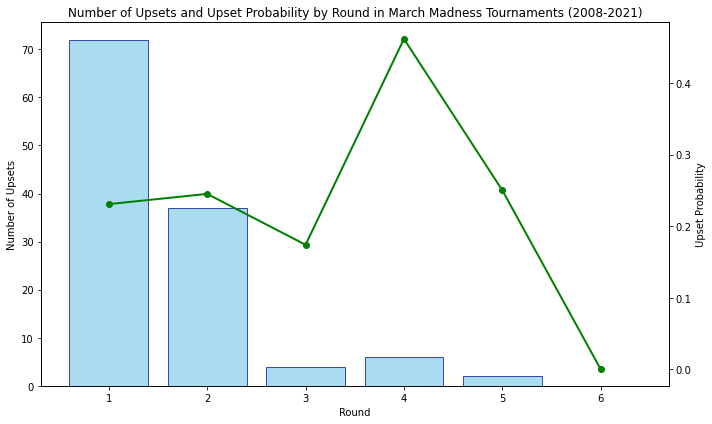

In [9]:
# Grouping the data by 'ROUND' and summing the 'UPSET5' values for each round
upsets_by_round = scores_filtered.groupby('ROUND')['UPSET5'].sum()

# Grouping the data by 'ROUND' and calculating the upset probability for each round
upset_probability_by_round = scores_filtered.groupby('ROUND')['UPSET5'].mean()

# Creating the bar graph for number of upsets
plt.figure(figsize=(10, 6))  # Adjust the figure size as per your preference

# Bar chart for number of upsets
bar_chart = plt.bar(upsets_by_round.index, upsets_by_round.values, color='skyblue', edgecolor='darkblue', alpha=0.7, label='Number of Upsets')

# Adding labels and title
plt.xlabel('Round')
plt.ylabel('Number of Upsets')
plt.title('Number of Upsets and Upset Probability by Round in March Madness Tournaments (2008-2021)')

# Secondary y-axis for the line graph
ax2 = plt.twinx()

# Line graph for upset probability
line_graph = ax2.plot(upset_probability_by_round.index, upset_probability_by_round.values, marker='o', color='green', linestyle='-', linewidth=2, label='Upset Probability')

# Adding labels for the secondary y-axis
ax2.set_ylabel('Upset Probability')

# Displaying the plot
plt.tight_layout()  # To avoid any label cutoff
plt.show()


In [10]:
#combine scores and gamedata

#step1, add FTEAM and UTEAM columns
def get_teams(row):
    if row['WSEED'] < row['LSEED']:
        return pd.Series([row['WTEAM'], row['LTEAM']])
    else:
        return pd.Series([row['LTEAM'], row['WTEAM']])

# Apply the function to each row to get FTEAM and UTEAM values
scores_filtered[['FTEAM', 'UTEAM']] = scores_filtered.apply(get_teams, axis=1)

scores_filtered["FTEAM COM"] = (
    scores_filtered["YEAR"].astype(str)
    + "_"
    + scores_filtered["FTEAM"])

scores_filtered["UTEAM COM"] = (
    scores_filtered["YEAR"].astype(str)
    + "_"
    + scores_filtered["UTEAM"])

scores_filtered

,YEAR,ROUND,WSEED,WTEAM,WSCORE,LSEED,LTEAM,LSCORE,UPSET,SEED COMBINATION,COMBINATION COUNT,UPSET5,GAME ID,WSEED COM,LSEED COM,FTEAM,UTEAM,FTEAM COM,UTEAM COM
1,2021,5,1,Gonzaga,93,11,UCLA,90,0,1&11,9,0,1,1_Gonzaga_5_93,11_UCLA_5_90,Gonzaga,UCLA,2021_Gonzaga,2021_UCLA
3,2021,4,2,Houston,67,12,Oregon St.,61,0,2&12,2,0,2,2_Houston_4_67,12_Oregon St._4_61,Houston,Oregon St.,2021_Houston,2021_Oregon St.
5,2021,4,11,UCLA,51,1,Michigan,49,1,1&11,9,1,3,11_UCLA_4_51,1_Michigan_4_49,Michigan,UCLA,2021_Michigan,2021_UCLA
6,2021,4,1,Gonzaga,85,6,Southern California,66,0,1&6,12,0,4,1_Gonzaga_4_85,6_Southern California_4_66,Gonzaga,Southern California,2021_Gonzaga,2021_Southern California
7,2021,3,2,Houston,62,11,Syracuse,46,0,2&11,18,0,5,2_Houston_3_62,11_Syracuse_3_46,Houston,Syracuse,2021_Houston,2021_Syracuse
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,2008,1,12,Villanova,75,5,Clemson,69,1,5&12,144,1,504,12_Villanova_1_75,5_Clemson_1_69,Clemson,Villanova,2008_Clemson,2008_Villanova
854,2008,1,11,Kansas St.,80,6,Southern California,67,1,6&11,144,1,505,11_Kansas St._1_80,6_Southern California_1_67,Southern California,Kansas St.,2008_Southern California,2008_Kansas St.
855,2008,1,6,Oklahoma,72,11,St. Joseph's,64,0,6&11,144,0,506,6_Oklahoma_1_72,11_St. Joseph's_1_64,Oklahoma,St. Joseph's,2008_Oklahoma,2008_St. Joseph's
857,2008,1,3,Stanford,77,14,Cornell,53,0,3&14,144,0,507,3_Stanford_1_77,14_Cornell_1_53,Stanford,Cornell,2008_Stanford,2008_Cornell


In [11]:
#change names
gamedata_filtered.loc[:, 'TEAM'] = gamedata_filtered['TEAM'].str.replace('USC', 'Southern California')
gamedata_filtered.loc[:, 'TEAM'] = gamedata_filtered['TEAM'].str.replace('Miami FL', 'Miami (Fla.)')
gamedata_filtered.loc[:, 'TEAM'] = gamedata_filtered['TEAM'].str.replace('Loyola Chicago', 'Loyola (Ill.)')
gamedata_filtered.loc[:, 'TEAM'] = gamedata_filtered['TEAM'].str.replace("Saint Mary's", "St. Mary's (Cal.)")
gamedata_filtered.loc[:, 'TEAM'] = gamedata_filtered['TEAM'].str.replace("BYU", "Brigham Young")
gamedata_filtered.loc[:, 'TEAM'] = gamedata_filtered['TEAM'].str.replace("Saint", "St.")
gamedata_filtered.loc[:, 'TEAM'] = gamedata_filtered['TEAM'].str.replace("Virginia ", "Virginia")
gamedata_filtered.loc[:, 'TEAM'] = gamedata_filtered['TEAM'].str.replace("VCU", "Virginia Commonwealth")
gamedata_filtered.loc[:, 'TEAM'] = gamedata_filtered['TEAM'].str.replace("VirginiaTech", "Virginia Tech")
gamedata_filtered.loc[:, 'TEAM'] = gamedata_filtered['TEAM'].str.replace("UCF", "Central Florida")
gamedata_filtered.loc[:, 'TEAM'] = gamedata_filtered['TEAM'].str.replace("SMU", "Southern Methodist")

teamdata_filtered["TEAM COM"] = (teamdata_filtered["YEAR"].astype(str) + "_" + teamdata_filtered["TEAM"])

teamdata_filtered.head()

/var/folders/3c/x47h9__n2nsb_4tp8t5ynyvm0000gn/T/ipykernel_26767/1742946788.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gamedata_filtered.loc[:, 'TEAM'] = gamedata_filtered['TEAM'].str.replace('USC', 'Southern California')
/var/folders/3c/x47h9__n2nsb_4tp8t5ynyvm0000gn/T/ipykernel_26767/1742946788.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gamedata_filtered.loc[:, 'TEAM'] = gamedata_filtered['TEAM'].str.replace('Miami FL', 'Miami (Fla.)')
/var/folders/3c/x47h9__n2nsb_4tp8t5ynyvm0000gn/T/ipy

,YEAR,SEED,TEAM,ROUND ADVANCED,KENPOM ADJUSTED EFFICIENCY,KENPOM ADJUSTED OFFENSE,KENPOM ADJUSTED DEFENSE,KENPOM ADJUSTED TEMPO,BARTTORVIK ADJUSTED EFFICIENCY,BARTTORVIK ADJUSTED OFFENSE,...,OP ASSIST %,OP O REB %,OP D REB %,BLOCKED %,TURNOVER % DEFENSE,WINS ABOVE BUBBLE,WIN %,POINTS PER POSSESSION OFFENSE,POINTS PER POSSESSION DEFENSE,TEAM COM
68,2021,1,Baylor,1,29.5,123.3,93.8,68.4,29.8,123.3,...,51.7,30.9,62.5,10.0,24.6,6.7,91.67,1.196,0.941,2021_Baylor
69,2021,1,Gonzaga,2,36.6,126.1,89.5,74.8,35.7,125.3,...,44.8,23.4,69.6,6.9,20.3,8.5,100.00,1.224,0.918,2021_Gonzaga
70,2021,1,Michigan,8,30.8,119.4,88.6,66.8,26.9,117.7,...,42.5,24.8,70.6,7.0,15.1,7.1,83.33,1.122,0.962,2021_Michigan
71,2021,1,Illinois,32,30.6,119.0,88.3,70.7,26.6,117.4,...,44.3,22.2,67.0,9.5,16.1,8.8,79.31,1.124,0.956,2021_Illinois
72,2021,2,Houston,4,28.8,118.9,90.1,64.9,29.6,119.0,...,51.6,28.0,60.6,7.3,21.6,4.0,88.46,1.157,0.884,2021_Houston


In [12]:
# Merge the DataFrames based on 'FTEAM COM' matching with 'TEAM COM'
merged_data = scores_filtered.merge(
    teamdata_filtered.add_suffix('_F'),
    left_on='FTEAM COM',
    right_on='TEAM COM_F',
    how='left'
)

# Merge the DataFrames based on 'UTEAM COM' matching with 'TEAM COM'
merged_data = merged_data.merge(
    teamdata_filtered.add_suffix('_U'),
    left_on='UTEAM COM',
    right_on='TEAM COM_U',
    how='left'
)

merged_data = merged_data.drop(columns=['FTEAM', 'UTEAM','WSEED', 'LSEED', 'WTEAM', 'LTEAM', 'WSCORE', 'LSCORE', 'UPSET', 'SEED COMBINATION', 'COMBINATION COUNT', 'GAME ID', 'WSEED COM', 'LSEED COM', 'FTEAM COM', 'UTEAM COM', 'ROUND ADVANCED_F', 'ROUND ADVANCED_U', 'TEAM COM_F', 'TEAM COM_U', 'TEAM_F', 'TEAM_U', 'YEAR_F', 'YEAR_U' ])

merged_data = merged_data.dropna()

merged_data.head()

,YEAR,ROUND,UPSET5,SEED_F,KENPOM ADJUSTED EFFICIENCY_F,KENPOM ADJUSTED OFFENSE_F,KENPOM ADJUSTED DEFENSE_F,KENPOM ADJUSTED TEMPO_F,BARTTORVIK ADJUSTED EFFICIENCY_F,BARTTORVIK ADJUSTED OFFENSE_F,...,3PT RATE DEFENSE_U,OP ASSIST %_U,OP O REB %_U,OP D REB %_U,BLOCKED %_U,TURNOVER % DEFENSE_U,WINS ABOVE BUBBLE_U,WIN %_U,POINTS PER POSSESSION OFFENSE_U,POINTS PER POSSESSION DEFENSE_U
0,2021,5,0,1.0,36.6,126.1,89.5,74.8,35.7,125.3,...,39.0,49.4,24.2,69.2,7.1,17.6,2.6,65.38,1.083,1.019
1,2021,4,0,2.0,28.8,118.9,90.1,64.9,29.6,119.0,...,37.7,52.2,29.4,70.2,7.8,18.5,0.4,57.14,1.043,1.045
2,2021,4,1,1.0,30.8,119.4,88.6,66.8,26.9,117.7,...,39.0,49.4,24.2,69.2,7.1,17.6,2.6,65.38,1.083,1.019
4,2021,3,0,2.0,28.8,118.9,90.1,64.9,29.6,119.0,...,43.9,68.6,33.8,69.7,8.9,20.8,0.5,64.00,1.082,1.009
5,2021,3,0,3.0,21.5,111.5,90.0,73.1,18.8,110.1,...,32.0,44.3,33.0,76.8,9.4,18.2,-4.9,56.52,1.091,1.066


In [31]:
import csv

with open('merged_data.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(merged_data.columns)
    writer.writerows(merged_data.to_numpy())

In [13]:
##### perform ANOVA to select important features #####

# Split the data into features (X) and target variable (y)
X = merged_data.drop(columns=['UPSET5'])
y = merged_data['UPSET5']

# Compute ANOVA F-value and p-value for each feature
f_scores, p_values = f_classif(X, y)

# Create a DataFrame to store the F-value and p-value for each feature
anova_results = pd.DataFrame({'Feature': X.columns, 'F-Score': f_scores, 'p-value': p_values})

# Sort the DataFrame by F-Score in descending order to see the most significant features first
anova_results = anova_results.sort_values(by='F-Score', ascending=False)

# Print or analyze the anova_results DataFrame to identify significant features
anova_results.head(30)


,Feature,F-Score,p-value
10,BARTHAG_F,44.735574,6.899160e-11
7,BARTTORVIK ADJUSTED EFFICIENCY_F,43.040659,1.515662e-10
3,KENPOM ADJUSTED EFFICIENCY_F,37.841246,1.732121e-09
44,BARTTORVIK ADJUSTED EFFICIENCY_U,37.252041,2.287699e-09
47,BARTHAG_U,36.902496,2.698781e-09
40,KENPOM ADJUSTED EFFICIENCY_U,35.701817,4.766732e-09
72,WINS ABOVE BUBBLE_U,31.272375,3.953434e-08
48,ELITE SOS_U,24.470318,1.077659e-06
35,WINS ABOVE BUBBLE_F,23.860049,1.455085e-06
46,BARTTORVIK ADJUSTED DEFENSE_U,22.929026,2.303543e-06


In [14]:
# keep top 30 variables
top_30_variables = anova_results.head(30)['Feature']

# Filter the 'merged_gameresult' DataFrame to keep only the top 30 variables
merged_top30 = merged_data[top_30_variables]

In [15]:
##### logistic regression #####

In [16]:
X = merged_top30  # Features (top 30 variables)
y = merged_data['UPSET5']  # Target variable

# Split the data into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create the logistic regression model
logreg_model = LogisticRegression()

# Train the model on the training data
logreg_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logreg_model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.7878787878787878
Confusion Matrix:
[[96  5]
 [23  8]]


/Users/codygreene/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


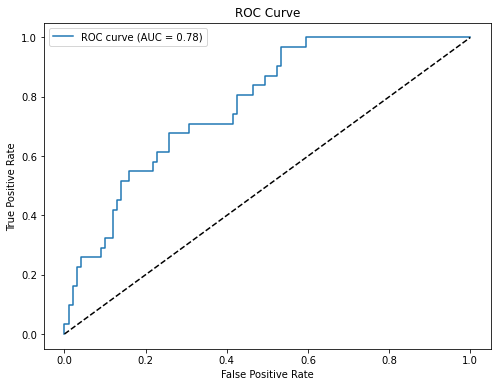

In [17]:
# Get the predicted probabilities for the positive class
y_probs = logreg_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


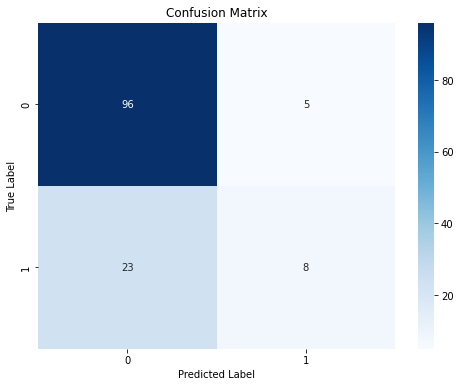

In [18]:
# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [19]:
X = merged_top30  # Features (top 30 variables)
y = merged_data['UPSET5']  # Target variable

# Create the logistic regression model
logreg_model = LogisticRegression()

cv_scores = cross_val_score(logreg_model, X, y, cv=10, scoring='accuracy')

# Print the cross-validation accuracy scores for each fold
print("Cross-validation accuracy scores:")
print(cv_scores)

# Calculate the average cross-validation accuracy
average_cv_accuracy = cv_scores.mean()
print("Average cross-validation accuracy:", average_cv_accuracy)


Cross-validation accuracy scores:
[0.81818182 0.79545455 0.72727273 0.79545455 0.75       0.79545455
 0.72727273 0.68181818 0.79545455 0.77272727]
Average cross-validation accuracy: 0.7659090909090909


/Users/codygreene/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/codygreene/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

In [20]:
##### random forest model #####

In [21]:
# Create the Random Forest model
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
random_forest_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = random_forest_model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.7575757575757576
Confusion Matrix:
[[95  6]
 [26  5]]


In [22]:
cv_scores = cross_val_score(random_forest_model, X, y, cv=10, scoring='accuracy')

# Print the cross-validation accuracy scores for each fold
print("Cross-validation accuracy scores:")
print(cv_scores)

# Calculate the average cross-validation accuracy
average_cv_accuracy = cv_scores.mean()
print("Average cross-validation accuracy:", average_cv_accuracy)

Cross-validation accuracy scores:
[0.75       0.77272727 0.75       0.77272727 0.77272727 0.75
 0.68181818 0.70454545 0.77272727 0.72727273]
Average cross-validation accuracy: 0.7454545454545455


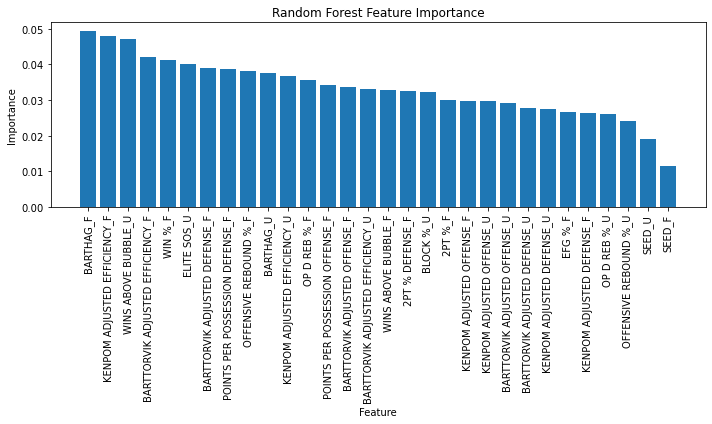

In [23]:
# Fit the Random Forest model on the entire dataset
random_forest_model.fit(X, y)

# Get feature importances from the model
feature_importances = random_forest_model.feature_importances_

# Create a DataFrame to associate each feature with its importance score
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance score in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()


In [24]:
##### Gradient Boosting Model #####

In [25]:
# Create the Gradient Boosting model
gradient_boosting_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
gradient_boosting_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gradient_boosting_model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.7651515151515151
Confusion Matrix:
[[93  8]
 [23  8]]


In [26]:
#cross validation
cv_scores = cross_val_score(gradient_boosting_model, X, y, cv=10, scoring='accuracy')

# Print the cross-validation accuracy scores for each fold
print("Cross-validation accuracy scores:")
print(cv_scores)

# Calculate the average cross-validation accuracy
average_cv_accuracy = cv_scores.mean()
print("Average cross-validation accuracy:", average_cv_accuracy)


Cross-validation accuracy scores:
[0.81818182 0.77272727 0.79545455 0.72727273 0.68181818 0.77272727
 0.65909091 0.70454545 0.79545455 0.70454545]
Average cross-validation accuracy: 0.7431818181818182


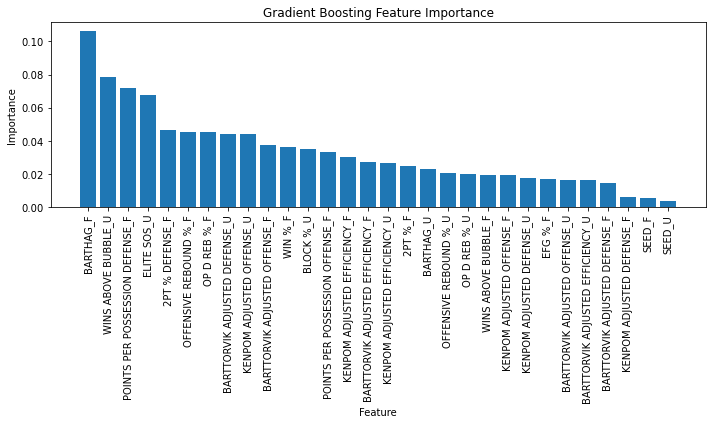

In [27]:
# Fit the Gradient Boosting model on the entire dataset
gradient_boosting_model.fit(X, y)

# Get feature importances from the model
feature_importances = gradient_boosting_model.feature_importances_

# Create a DataFrame to associate each feature with its importance score
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance score in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Gradient Boosting Feature Importance')
plt.tight_layout()
plt.show()


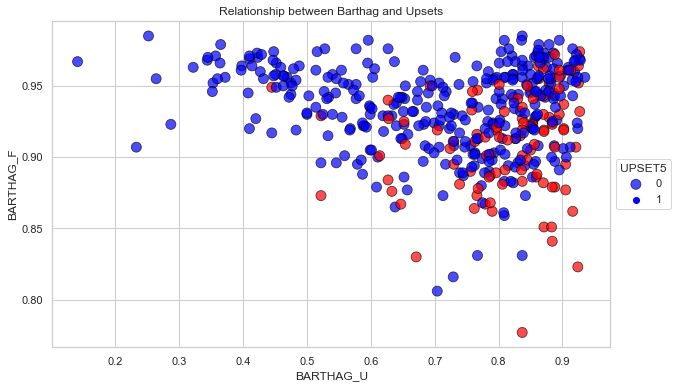

In [28]:
# Create a scatter plot using seaborn
sns.set(style='whitegrid')  # Set the plot style
plt.figure(figsize=(10, 6))  # Set the size of the figure

# Define a custom color palette for UPSET5 = 0 (blue) and UPSET5 = 1 (red)
colors = {0: 'blue', 1: 'red'}

sns.scatterplot(
    x='BARTHAG_U',
    y='BARTHAG_F',
    hue='UPSET5',
    palette=colors,  # Use the custom color palette
    data=merged_data,
    alpha=0.7,  # Set the transparency to 0.7 to distinguish overlapping points
    edgecolor='black',  # Add black edges around the points for better visibility
    s=100,  # Set the size of the markers
)

# Add labels and title
plt.xlabel('BARTHAG_U')
plt.ylabel('BARTHAG_F')
plt.title('Relationship between Barthag and Upsets')

# Move the legend outside the plot box
plt.legend(title='UPSET5', loc='center left', bbox_to_anchor=(1, 0.5), labels=['0', '1'])

# Show the plot
plt.show()


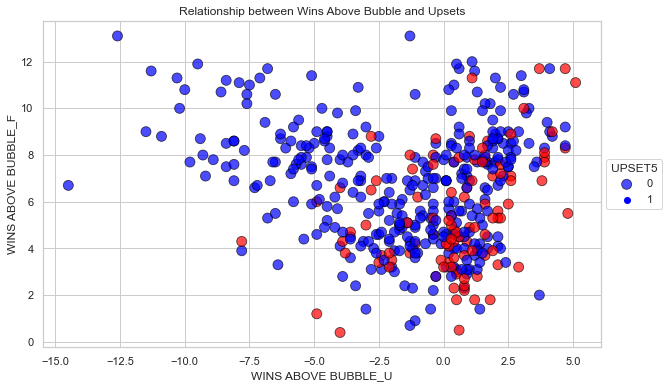

In [29]:
# Create a scatter plot using seaborn
sns.set(style='whitegrid')  # Set the plot style
plt.figure(figsize=(10, 6))  # Set the size of the figure

# Define a custom color palette for UPSET5 = 0 (blue) and UPSET5 = 1 (red)
colors = {0: 'blue', 1: 'red'}

sns.scatterplot(
    x='WINS ABOVE BUBBLE_U',
    y='WINS ABOVE BUBBLE_F',
    hue='UPSET5',
    palette=colors,  # Use the custom color palette
    data=merged_data,
    alpha=0.7,  # Set the transparency to 0.7 to distinguish overlapping points
    edgecolor='black',  # Add black edges around the points for better visibility
    s=100,  # Set the size of the markers
)

# Add labels and title
plt.xlabel('WINS ABOVE BUBBLE_U')
plt.ylabel('WINS ABOVE BUBBLE_F')
plt.title('Relationship between Wins Above Bubble and Upsets')

# Move the legend outside the plot box
plt.legend(title='UPSET5', loc='center left', bbox_to_anchor=(1, 0.5), labels=['0', '1'])

# Show the plot
plt.show()
